# Load hdf file and post-process

For a given model (as guitar_model above), set internal data using hdf5 input. Useful for post-processing only. 

Prerequisite : a complete simulation saved in hdf file (e.g. results of run.py)

### Usage: 

* call load_model function : create a model (dynamical system, interactions and so on) and load results from a previous simu from hdf file
* call post-processing tools

In [1]:
# standard python packages
import sys
import time
import os
from model_tools import load_model
# visu
import matplotlib.pyplot as plt
%matplotlib inline

Ready to start simulation for frequency 15200.0.
Save output every 1 time steps.


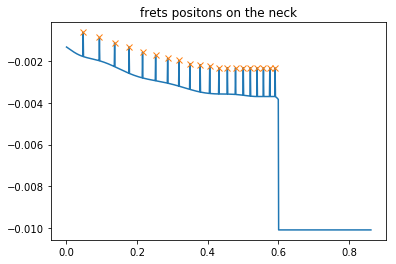

In [12]:
guitar_model, guitar_string, frets = load_model("./results/g_864_15200.h5")

In [13]:
guitar_string.max_coords

array([ 0.0078,  0.64  ])

## Plot trajectories
Use plotTraj(dynamical_system, list of dof to be plotted)

If list of dof is not set, all dof will be plotted.

Result = dof as a function of time +  zoom specific ranges (as in the paper)

To save the resulting figure(s), add argument filename when calling plotTraj

Arg 'iplot' is used to change figure number. Set same iplot if you want to plot all curves on the same figure.
Default iplot=0.

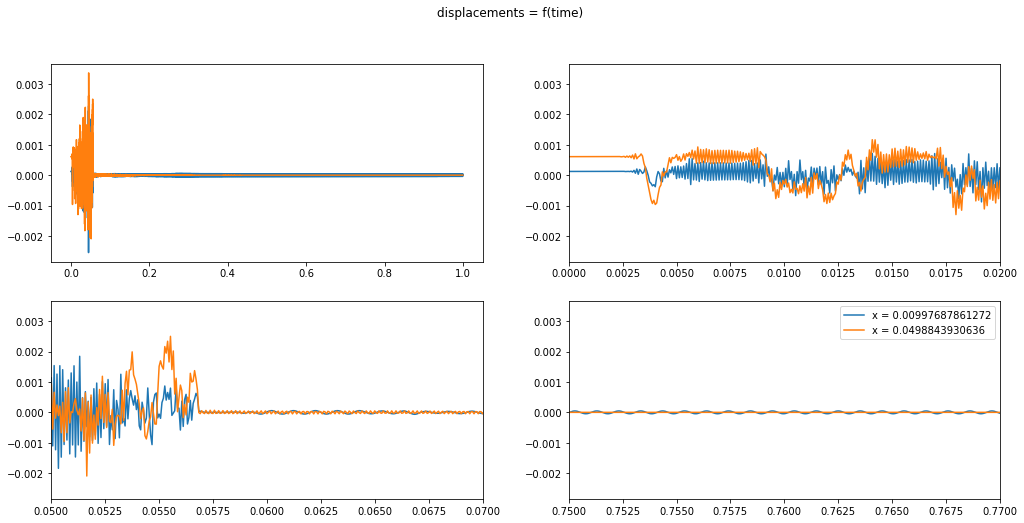

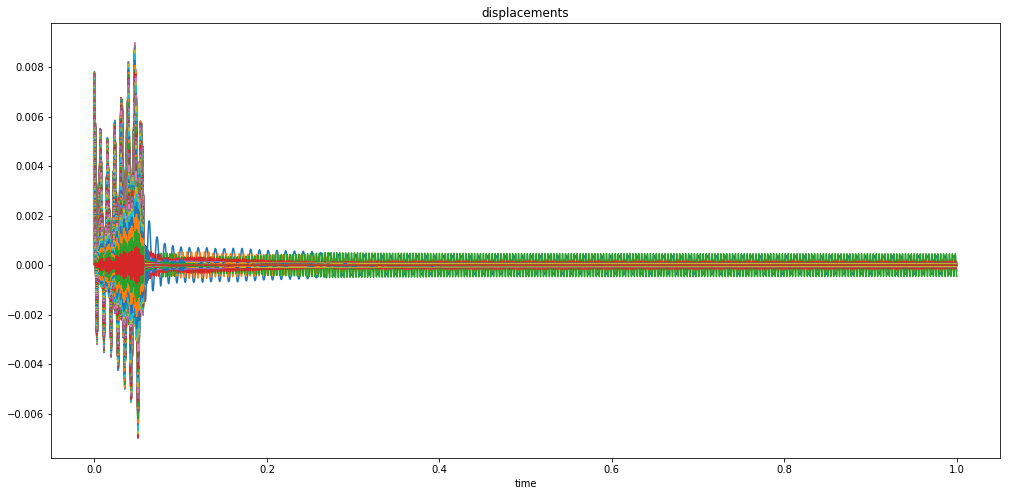

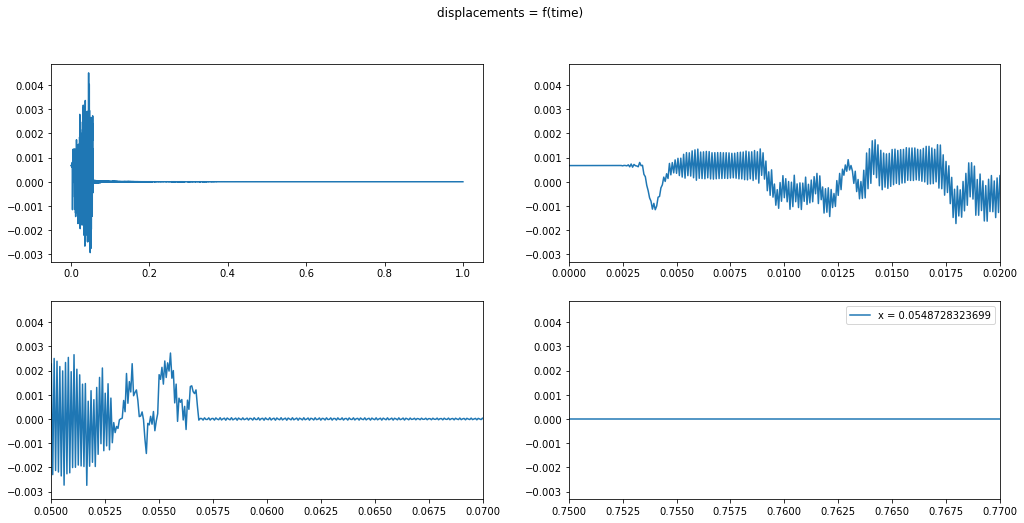

In [14]:
# Plot dof 10 and 50
guitar_model.plot_traj(guitar_string, dof=[10, 50], iplot=0)
# Plot all dof
guitar_model.plot_traj(guitar_string, iplot=1)
# Plot dof 55 and save result in displacements_55.pdf
guitar_model.plot_traj(guitar_string, dof=[55], filename='displacements_55.pdf', iplot=2)

## Plot modes

Use guitar_model.plot_modes(guitar_string,plot_shape)

plot_shape = (x,y) where x,y is the resolution of the grid of plots.

Example: 
plot_modes(guitar_string, (4,2)) : splits time range in 8 and plots dof=f(x) for those 8 time instants on 8 figures


Set filename arg to save resulting figure in a file.

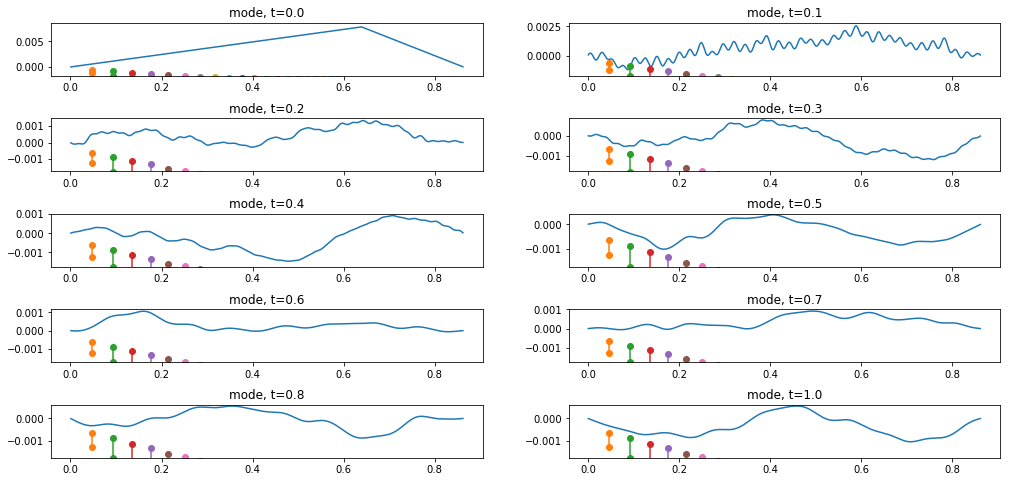

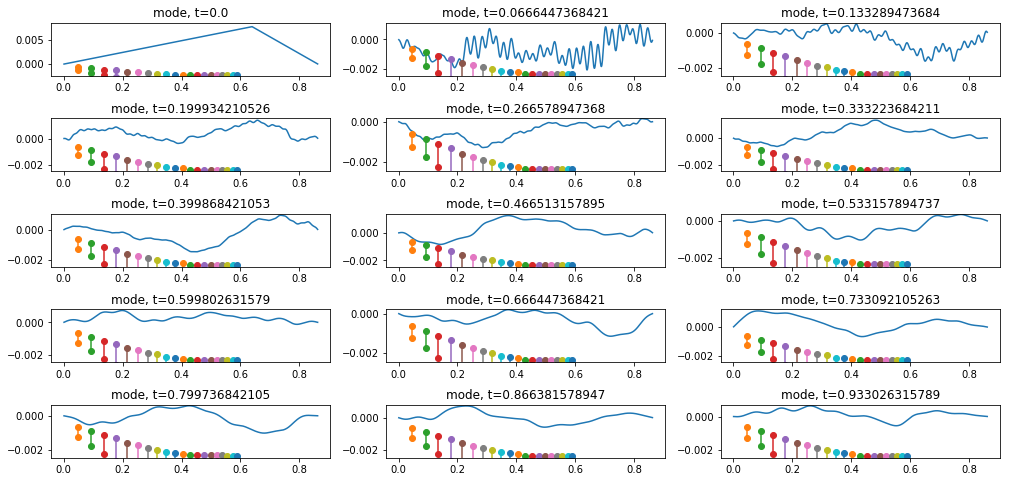

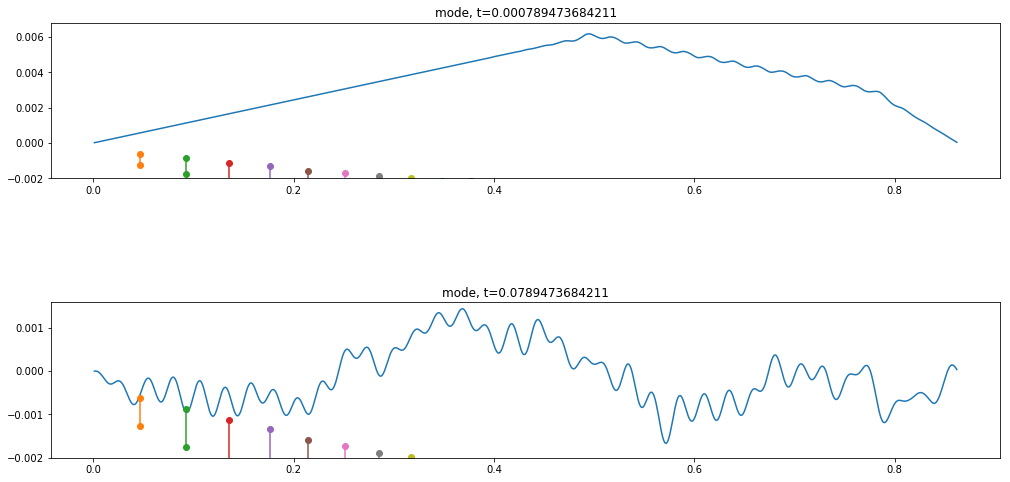

In [15]:
# Plot 10 figures on two columns, for 10 time instants
guitar_model.plot_modes(guitar_string,plot_shape=[5,2], iplot=0)
# Same thing but save output in modes.pdf
guitar_model.plot_modes(guitar_string,plot_shape=[5,3], filename='modes.pdf', iplot=1)
# plot modes for time[12] and time[5000] on one column
guitar_model.plot_modes(guitar_string, times =[12, 1200], plot_shape=(2,1), filename='modes2.pdf', iplot=2)

## Create a movie mode=f(time)

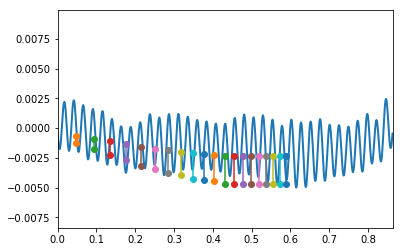

In [16]:
guitar_model.make_movie(guitar_string,'test.mp4')

<video controls src="test.mp4" />
#%%html
#<video width="320" height="240" controls>
#  <source src="./test.mp4" type="video/mp4">
#</video>

## Plot contactogram

    !! Works only if enable_interactions_output=True in model (guitar_model) constructor

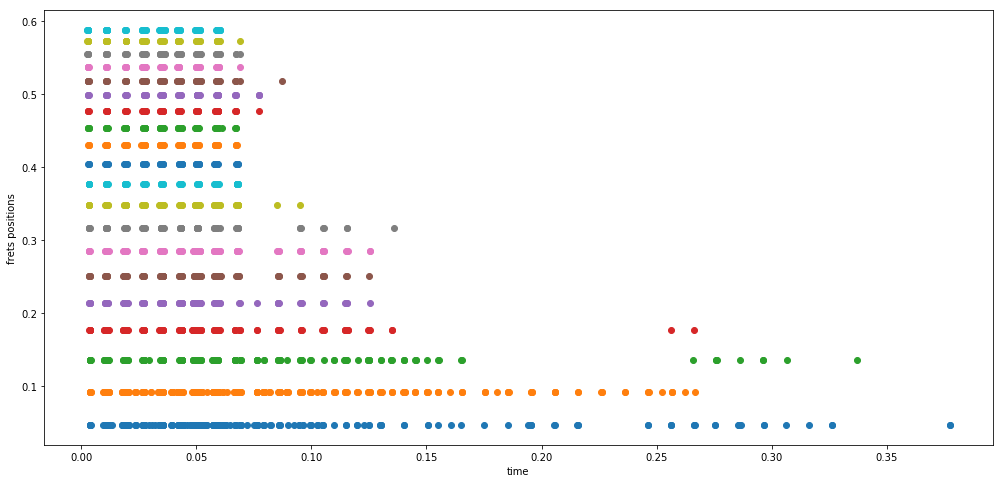

In [17]:
guitar_model.contactogram(guitar_string)